# Introduction

In this notebook, we are putting Deep Learning models in to practices.

With the dataset of ***360 Fruit***, which includes around a hundred of fruit families with hundreds images for each, we are using:
* A ***handmade-by-me CNN***.
* A state-of-the-OLD-art: ***LeNet5***
* Transform learning with the giant ***ResNet-152***
* Transform learning with the tiny ***SqueezeNet***

Then, each model practicing following by a classification report and a tunning.

At last, we will discuss which one is the best, why, how, and other questions.


***Dataset properties***

* Total number of images: 90483.
* Training set size: 67692 images (one fruit or vegetable per image).
* Test set size: 22688 images (one fruit or vegetable per image).
* Multi-fruits set size: 103 images (more than one fruit (or fruit class) per image)
* Number of classes: ***131*** (fruits and vegetables).
* Image size: ***100x100*** pixels.

# Import Packages

In [1]:
# Bases
import keras as k
import tensorflow as tf
from keras import backend as K

## data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, LayerNormalization, GlobalAveragePooling2D, AveragePooling2D

## plotting
import os
import numpy as np
import matplotlib.pyplot as plt

## callbacks
from keras.callbacks import TensorBoard
import time

from keras.applications import ResNet152
from keras import Input, Model

import sklearn
from sklearn.metrics import  classification_report, roc_curve

Using TensorFlow backend.


## Environment Configuration for GPU

As the VRAM of GPU is 3GB, not enough to work with cudnn, we will do some tricks force GPU to work.

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

memory_limit=1024
if gpus:
  # Create 2 virtual GPUs with 1GB memory each
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit),
         #tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit),
         tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPU, 2 Logical GPUs


In [3]:
tf.test.is_built_with_cuda()

True

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12067930824567493878
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6558053770790966327
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1073741824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3780154892045269550
physical_device_desc: "device: 0, name: GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4958943799766633031
physical_device_desc: "device: XLA_GPU device"
]


## Helpful Functions

In [6]:
# This function: plots images in the form of a 1 row x 5 cols grid.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Preprocessing Data

The dataset has the following directory ***structure***:

<pre>
<b>Fruit Images Dataset</b>
|__ <b>train</b>
    |______ <b>Apple Braeburn</b>: [0_100.jpg, ..]
    |______ <b>Apple Crimson Snow</b>: [0_100.jpg, ..] 
    ..
    |______ <b>Apple Watermelon</b>: [0_100.jpg, ..]
|__ <b>test</b>
    |______ <b>Apple Braeburn</b>: [0_100.jpg, ..]
    |______ <b>Apple Crimson Snow</b>: [0_100.jpg, ..] 
    ..
    |______ <b>Apple Watermelon</b>: [0_100.jpg, ..]
</pre>

***How to prepare data***

Format the images into appropriately pre-processed floating point tensors before feeding to the network:

1. Read images from the disk.
2. Decode contents of these images and convert it into proper grid format as per their RGB content.
3. Convert them into floating point tensors.
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done with the `ImageDataGenerator` class provided by `tf.keras`, which can:
* Read images and preprocess them into proper tensors. 
* Set up generators that convert these images into batches of tensors — helpful when training the network.

In [7]:
# Generator
train_generator = ImageDataGenerator(rescale=1/255)
test_generator = ImageDataGenerator(rescale=1/255)

In [8]:
# Variable for pre-processing and training
batch_size = 128
epochs = 15

IMG_HEIGHT = 100
IMG_WIDTH = 100

num_classes = 131

class_mode = 'categorical'

where_train = '/home/maihai/GitHub/Fruit-Images-Dataset/train'
where_test  = '/home/maihai/GitHub/Fruit-Images-Dataset/test'

After defining the generators, the `flow_from_directory` method will:
* Load images from the disk,
* Applies rescaling,
* Applies resizes images into the required dimensions.

In [9]:
# Train set
train_data_gen = train_generator.flow_from_directory(directory=where_train, 
                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                         class_mode=class_mode,
                                         shuffle=False,
                                         batch_size=batch_size)


Found 67692 images belonging to 131 classes.


In [10]:
# Test set
test_data_gen = test_generator.flow_from_directory(directory=where_test,
                                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                                        class_mode=class_mode,
                                        shuffle=False,
                                        batch_size=batch_size)

Found 22688 images belonging to 131 classes.


In [11]:
# Set variables for model training later

num_train = train_data_gen.samples
num_test  = test_data_gen.samples

## Visualize Images

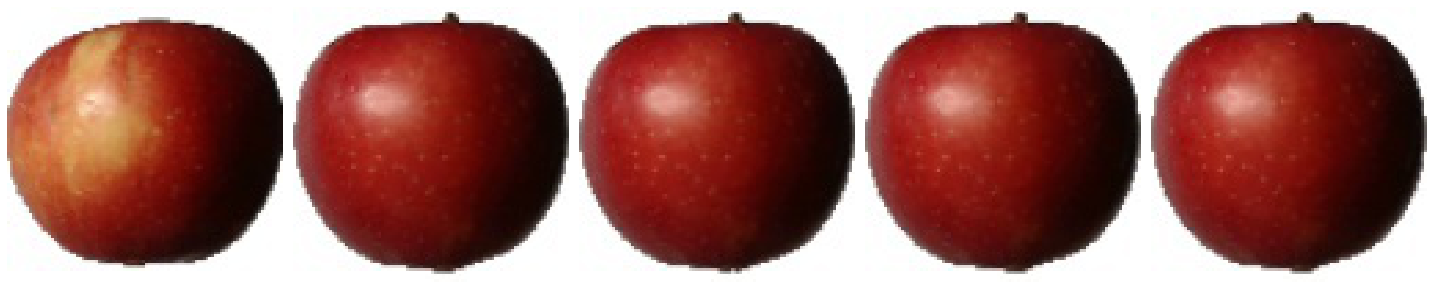

In [12]:
sample_training_images, _ = next(train_data_gen)

plotImages(sample_training_images[:5])

# Model - Version 1

## Fiting

In [18]:
model_baseline = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dense(131, activation = 'softmax')
])

model_baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0

In [19]:
model_baseline.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy', 'AUC'])

In [20]:
# Set up TensorBoard
NAME = 'Handmade_model_baseline_{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

In [21]:
%%time
# Train model_baseline
history = model_baseline.fit(train_data_gen,
                             steps_per_epoch=num_train // batch_size,
                             epochs=epochs,
                             callbacks=[tensorboard])

Epoch 1/15
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
528/528 [==============================] - 26s 48ms/step - loss: 4.9750 - categorical_accuracy: 0.0041 - auc: 0.5321
Epoch 2/15
528/528 [==============================] - 25s 48ms/step - loss: 4.8055 - categorical_accuracy: 0.0000e+00 - auc: 0.5882
Epoch 3/15
528/528 [==============================] - 25s 47ms/step - loss: 4.9192 - categorical_accuracy: 0.0073 - auc: 0.4844
Epoch 4/15
528/528 [==============================] - 25s 48ms/step - loss: 4.8987 - categorical_accuracy: 0.0000e+00 - auc: 0.5000
Epoch 5/15
528/528 [==============================] - 25s 47ms/step - loss: 4.8965 - categorical_accuracy: 0.0000e+00 - auc: 0.5000
Epoch 6/15
528/528 [==============================] - 24s 46ms/step - loss: 4.8946 - categorical_accuracy: 0.0000e+00 - auc: 0.5000
Epoch 7/15
528/528 [==============================] - 24s 46ms/step - loss: 4.8928 - categorical_accuracy: 0.0000e+00 - auc: 0.5000
Epo

In [22]:
model_baseline.save('baseline_model_NOTHING_more.hdf5')

where_to_save = 'baseline_model_NOTHING_more_weights'
model_baseline.save_weights(filepath=where_to_save,
                            overwrite=True)

In [56]:
# Clear VRAM
K.clear_session()

## Learning Curve

In [46]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'auc', 'val_loss', 'val_categorical_accuracy', 'val_auc'])

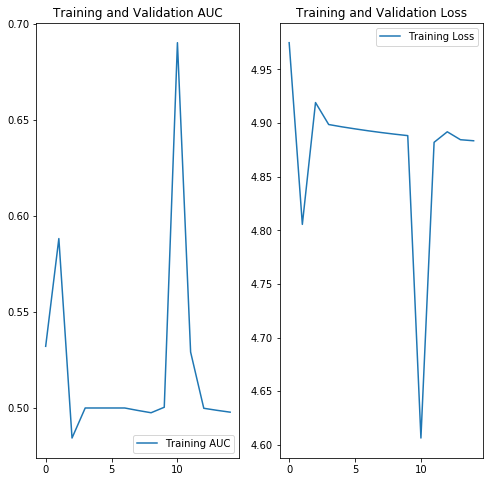

In [23]:
auc = history.history['auc']
#val_auc = history.history['val_auc']

loss=history.history['loss']
#val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, auc, label='Training AUC')
#plt.plot(epochs_range, val_auc, label='Validation AUC')
plt.legend(loc='lower right')
plt.title('Training and Validation AUC')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
#plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Clasification report

model_baseline.load_weights('Handmade_model_baseline_weights')

In [24]:
y_pred = model_baseline.predict(test_data_gen,
                                batch_size=batch_size,
                                    steps=num_test/batch_size,
                                    verbose=1)
y_pred = np.argmax(y_pred[:num_test], axis=1)

178/177 [==============================] - 8s 45ms/step


In [27]:
y_true = test_data_gen.labels

In [28]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       164
           1       0.00      0.00      0.00       148
           2       0.00      0.00      0.00       160
           3       0.00      0.00      0.00       164
           4       0.00      0.00      0.00       161
           5       0.00      0.00      0.00       164
           6       0.00      0.00      0.00       152
           7       0.00      0.00      0.00       164
           8       0.00      0.00      0.00       164
           9       0.00      0.00      0.00       144
          10       0.00      0.00      0.00       166
          11       0.00      0.00      0.00       164
          12       0.00      0.00      0.00       219
          13       0.00      0.00      0.00       164
          14       0.00      0.00      0.00       143
          15       0.00      0.00      0.00       166
          16       0.00      0.00      0.00       166
          17       0.00    

/home/maihai/anaconda3/envs/DLgpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Inspection

In [51]:
y_pred[:100]

array([ 8, 70,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  0,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

# Model - Version 2

## Fiting

In [28]:
model_baseline = Sequential([
    Conv2D(32, (11, 11), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    
    Conv2D(64, (11, 11), padding='same', activation='relu'),
    MaxPooling2D(),
    
    Conv2D(128, (11, 11), padding='same', activation='relu'),
    MaxPooling2D(),
    
    Flatten(),
    Dense(120, activation='relu'),
    
    Dense(131, activation = 'softmax') # Output
])

model_baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      11648     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        247872    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 128)       991360    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0

In [16]:
model_baseline.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy', 'AUC'])

In [17]:
# Set up TensorBoard
NAME = 'Handmade_model_baseline_{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

In [18]:
%%time
# Train model_baseline
history = model_baseline.fit(train_data_gen,
                             steps_per_epoch=num_train // batch_size,
                             epochs=epochs,
                             callbacks=[tensorboard])

Epoch 1/15
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
528/528 [==============================] - 128s 243ms/step - loss: 5.0078 - categorical_accuracy: 0.0060 - auc: 0.4987
Epoch 2/15
528/528 [==============================] - 124s 235ms/step - loss: 4.9019 - categorical_accuracy: 0.0044 - auc: 0.5000
Epoch 3/15
528/528 [==============================] - 124s 234ms/step - loss: 4.8996 - categorical_accuracy: 5.9203e-04 - auc: 0.5000
Epoch 4/15
528/528 [==============================] - 123s 234ms/step - loss: 4.8975 - categorical_accuracy: 0.0000e+00 - auc: 0.5000
Epoch 5/15
528/528 [==============================] - 125s 237ms/step - loss: 4.8954 - categorical_accuracy: 5.9203e-05 - auc: 0.5000
Epoch 6/15
528/528 [==============================] - 129s 244ms/step - loss: 4.8937 - categorical_accuracy: 0.0099 - auc: 0.5000
Epoch 7/15
528/528 [==============================] - 134s 254ms/step - loss: 4.8920 - categorical_accuracy: 5.9203e-05 - auc: 

In [19]:
model_baseline.save('baseline_ver_2.hdf5')

where_to_save = 'baseline_ver_2_weights'
model_baseline.save_weights(filepath=where_to_save,
                            overwrite=True)

In [43]:
# Clear VRAM
K.clear_session()

## Learning Curve

In [20]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'auc'])

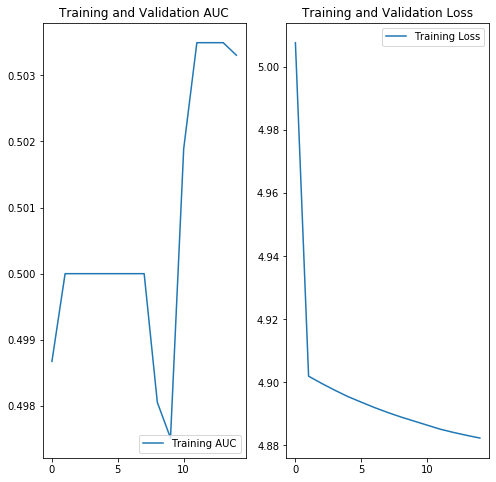

In [21]:
auc = history.history['auc']
#val_auc = history.history['val_auc']

loss=history.history['loss']
#val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, auc, label='Training AUC')
#plt.plot(epochs_range, val_auc, label='Validation AUC')
plt.legend(loc='lower right')
plt.title('Training and Validation AUC')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
#plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Clasification report

In [ ]:
# model_baseline.load_weights('baseline_ver_2_weights')

In [30]:
y_pred = model_baseline.predict(test_data_gen,
                                    steps=num_test/batch_size,
                                    verbose=1)
y_pred = np.argmax(y_pred, axis=1)

178/177 [==============================] - 11s 61ms/step


In [31]:
y_true = test_data_gen.labels

In [32]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       164
           1       0.00      0.00      0.00       148
           2       0.00      0.00      0.00       160
           3       0.00      0.00      0.00       164
           4       0.00      0.00      0.00       161
           5       0.00      0.00      0.00       164
           6       0.00      0.00      0.00       152
           7       0.00      0.00      0.00       164
           8       0.00      0.00      0.00       164
           9       0.00      0.00      0.00       144
          10       0.00      0.00      0.00       166
          11       0.00      0.00      0.00       164
          12       0.00      0.00      0.00       219
          13       0.00      0.00      0.00       164
          14       0.00      0.00      0.00       143
          15       0.00      0.00      0.00       166
          16       0.00      0.00      0.00       166
          17       0.00    

/home/maihai/anaconda3/envs/DLgpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Inspection

In [34]:
y_true.shape == y_pred.shape

True

In [36]:
y_true[0:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [42]:
np.unique(y_true)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130], dtype=int32)

In [37]:
y_pred[0:50]

array([44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44,
       44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44,
       44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44])

In [41]:
np.unique(y_pred)

array([44])

# Model - LeNet5

## Fiting

In [29]:
# Clear VRAM
K.clear_session()

In [39]:
model_baseline = Sequential([
    Conv2D(filters=6, input_shape=(IMG_HEIGHT, IMG_WIDTH ,3), kernel_size=5, strides=1, activation='relu'),
    AveragePooling2D(),
    
    Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    AveragePooling2D(),
    
    Flatten(),
    Dense(units=120, activation='relu'),
    Dense(units=84, activation='relu'),
    
    Dense(131, activation = 'softmax')
])

model_baseline.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 96, 96, 6)         456       
_________________________________________________________________
average_pooling2d_2 (Average (None, 48, 48, 6)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 16)        880       
_________________________________________________________________
average_pooling2d_3 (Average (None, 23, 23, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8464)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               1015800   
_________________________________________________________________
dense_3 (Dense)              (None, 84)               

In [40]:
model_baseline.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy', 'AUC'])

In [32]:
# Set up TensorBoard
NAME = 'Handmade_model_baseline_{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

In [41]:
%%time
# Train model_baseline
history = model_baseline.fit(train_data_gen,
                             steps_per_epoch=num_train // batch_size,
                             epochs=epochs,
                             callbacks=[tensorboard])

Epoch 1/15
528/528 [==============================] - 23s 43ms/step - loss: 4.9736 - categorical_accuracy: 0.0021 - auc: 0.5053
Epoch 2/15
528/528 [==============================] - 23s 43ms/step - loss: 4.9140 - categorical_accuracy: 0.0000e+00 - auc: 0.4939
Epoch 3/15
528/528 [==============================] - 23s 43ms/step - loss: 4.9010 - categorical_accuracy: 0.0101 - auc: 0.4998
Epoch 4/15
528/528 [==============================] - 23s 44ms/step - loss: 4.5462 - categorical_accuracy: 0.0106 - auc: 0.7187
Epoch 5/15
528/528 [==============================] - 24s 45ms/step - loss: 4.1599 - categorical_accuracy: 0.0173 - auc: 0.8456
Epoch 6/15
528/528 [==============================] - 24s 45ms/step - loss: 3.7445 - categorical_accuracy: 0.0242 - auc: 0.9058
Epoch 7/15
528/528 [==============================] - 24s 45ms/step - loss: 4.7043 - categorical_accuracy: 0.0073 - auc: 0.6725
Epoch 8/15
528/528 [==============================] - 24s 45ms/step - loss: 4.4968 - categorical_acc

In [23]:
model_baseline.save('LeNet5.hdf5')

where_to_save = 'LeNet5_weights'
model_baseline.save_weights(filepath=where_to_save,
                            overwrite=True)

## Learning Curve

In [42]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'auc'])

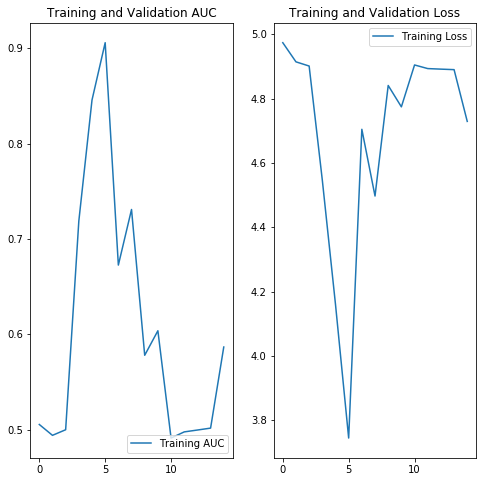

In [43]:
auc = history.history['auc']
#val_auc = history.history['val_auc']

loss=history.history['loss']
#val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, auc, label='Training AUC')
#plt.plot(epochs_range, val_auc, label='Validation AUC')
plt.legend(loc='lower right')
plt.title('Training and Validation AUC')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
#plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Clasification report

In [ ]:
# model_baseline.load_weights('baseline_ver_2_weights')

In [44]:
y_pred = model_baseline.predict(test_data_gen,
                                    steps=num_test/batch_size,
                                    verbose=1)
y_pred = np.argmax(y_pred, axis=1)

178/177 [==============================] - 7s 42ms/step


In [45]:
y_true = test_data_gen.labels

In [46]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       164
           1       0.00      0.00      0.00       148
           2       0.00      0.00      0.00       160
           3       0.00      0.00      0.00       164
           4       0.00      0.00      0.00       161
           5       0.00      0.00      0.00       164
           6       0.00      0.00      0.00       152
           7       0.00      0.00      0.00       164
           8       0.00      0.00      0.00       164
           9       0.00      0.00      0.00       144
          10       0.00      0.00      0.00       166
          11       0.00      0.00      0.00       164
          12       0.00      0.00      0.00       219
          13       0.00      0.00      0.00       164
          14       0.00      0.00      0.00       143
          15       0.00      0.00      0.00       166
          16       0.00      0.00      0.00       166
          17       0.00    

/home/maihai/anaconda3/envs/DLgpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model - Ver 3

## Fiting

In [26]:
# Clear VRAM
K.clear_session()

In [27]:
model_baseline = Sequential([
    Conv2D(filters=32, input_shape=(IMG_HEIGHT, IMG_WIDTH ,3), kernel_size=5, strides=1, activation='relu'),
    AveragePooling2D(),
    
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    AveragePooling2D(),
    
    Flatten(),
    Dense(units=120, activation='relu'),
    Dense(units=84, activation='relu'),
    
    Dense(131, activation = 'softmax')
])

model_baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        2432      
_________________________________________________________________
average_pooling2d (AveragePo (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
average_pooling2d_1 (Average (None, 23, 23, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 33856)             0         
_________________________________________________________________
dense (Dense)                (None, 120)               4062840   
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

In [28]:
model_baseline.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy', 'AUC'])

In [23]:
# Set up TensorBoard
NAME = 'Handmade_model_baseline_{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

In [29]:
%%time
# Train model_baseline
history = model_baseline.fit(train_data_gen,
                             steps_per_epoch=num_train // batch_size,
                             epochs=epochs,
                             callbacks=[tensorboard])

Epoch 1/15
528/528 [==============================] - 30s 57ms/step - loss: 5.0469 - categorical_accuracy: 0.0084 - auc: 0.5214
Epoch 2/15
528/528 [==============================] - 30s 57ms/step - loss: 4.9026 - categorical_accuracy: 0.0000e+00 - auc: 0.5000
Epoch 3/15
528/528 [==============================] - 30s 57ms/step - loss: 4.8992 - categorical_accuracy: 0.0000e+00 - auc: 0.5000
Epoch 4/15
528/528 [==============================] - 30s 57ms/step - loss: 4.8781 - categorical_accuracy: 6.3625e-04 - auc: 0.5563
Epoch 5/15
528/528 [==============================] - 30s 56ms/step - loss: 4.8163 - categorical_accuracy: 0.0089 - auc: 0.5968
Epoch 6/15
528/528 [==============================] - 30s 56ms/step - loss: 4.7032 - categorical_accuracy: 0.0024 - auc: 0.6170
Epoch 7/15
528/528 [==============================] - 30s 57ms/step - loss: 4.8964 - categorical_accuracy: 0.0146 - auc: 0.5000
Epoch 8/15
528/528 [==============================] - 30s 57ms/step - loss: 4.8902 - categor

In [23]:
model_baseline.save('Ver3.hdf5')

where_to_save = 'Ver3_weights'
model_baseline.save_weights(filepath=where_to_save,
                            overwrite=True)

## Learning Curve

In [30]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'auc'])

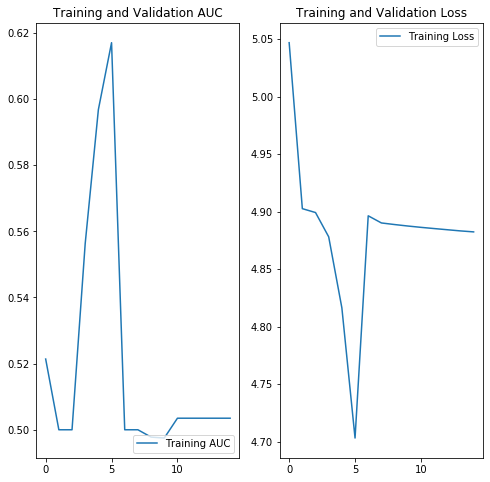

In [31]:
auc = history.history['auc']
#val_auc = history.history['val_auc']

loss=history.history['loss']
#val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, auc, label='Training AUC')
#plt.plot(epochs_range, val_auc, label='Validation AUC')
plt.legend(loc='lower right')
plt.title('Training and Validation AUC')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
#plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Clasification report

In [ ]:
# model_baseline.load_weights('baseline_ver_2_weights')

In [32]:
y_pred = model_baseline.predict(test_data_gen,
                                    steps=num_test/batch_size,
                                    verbose=1)
y_pred = np.argmax(y_pred, axis=1)

178/177 [==============================] - 10s 57ms/step


In [33]:
y_true = test_data_gen.labels

In [34]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       164
           1       0.00      0.00      0.00       148
           2       0.00      0.00      0.00       160
           3       0.00      0.00      0.00       164
           4       0.00      0.00      0.00       161
           5       0.00      0.00      0.00       164
           6       0.00      0.00      0.00       152
           7       0.00      0.00      0.00       164
           8       0.00      0.00      0.00       164
           9       0.00      0.00      0.00       144
          10       0.00      0.00      0.00       166
          11       0.00      0.00      0.00       164
          12       0.00      0.00      0.00       219
          13       0.00      0.00      0.00       164
          14       0.00      0.00      0.00       143
          15       0.00      0.00      0.00       166
          16       0.00      0.00      0.00       166
          17       0.00    

/home/maihai/anaconda3/envs/DLgpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
